<a href="https://colab.research.google.com/github/Ayanlola2002/Data-Science-Nigeria/blob/master/developing_Staff_promotion_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c intercampusai2019

  0% 0.00/234k [00:00<?, ?B/s]
100% 234k/234k [00:00<00:00, 73.5MB/s]
  0% 0.00/541k [00:00<?, ?B/s]
100% 541k/541k [00:00<00:00, 74.9MB/s]
  0% 0.00/242k [00:00<?, ?B/s]
100% 242k/242k [00:00<00:00, 33.7MB/s]


In [0]:
#unzippig the us-data file
from shutil import unpack_archive
#unpack_archive('all.zip')
unpack_archive('train.csv.zip')
unpack_archive('test.csv.zip')

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

In [0]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics


In [0]:
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

In [0]:
#train = pd.read_csv('train.csv',parse_dates=[['weblog_date'],['date_of_advert'],['last_advert_online']])
#test = pd.read_csv('test.csv',parse_dates=[weblog_date],[[date_of_advert],[last_advert_online])
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [0]:
sample=pd.read_csv('sample_submission2.csv')

In [10]:
sample.head()

,EmployeeNo,Promoted_or_Not
0,YAK/S/34385,1
1,YAK/S/27825,1
2,YAK/S/23870,1
3,YAK/S/54784,1
4,YAK/S/25058,1


In [0]:
train_copy=train.copy()
test_copy=test.copy()

In [12]:
##display the first five rows of the train dataset.
train.head()

,EmployeeNo,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,Promoted_or_Not
0,YAK/S/00001,Commercial Sales and Marketing,"MSc, MBA and PhD",Female,Direct Internal process,2,1986,12.500,2011,1,0,41,ANAMBRA,No,Married,No,No,0,0
1,YAK/S/00002,Customer Support and Field Operations,First Degree or HND,Male,Agency and others,2,1991,12.500,2015,0,0,52,ANAMBRA,Yes,Married,No,No,0,0
2,YAK/S/00003,Commercial Sales and Marketing,First Degree or HND,Male,Direct Internal process,2,1987,7.500,2012,0,0,42,KATSINA,Yes,Married,No,No,0,0
3,YAK/S/00004,Commercial Sales and Marketing,First Degree or HND,Male,Agency and others,3,1982,2.500,2009,0,0,42,NIGER,Yes,Single,No,No,1,0
4,YAK/S/00006,Information and Strategy,First Degree or HND,Male,Direct Internal process,3,1990,7.500,2012,0,0,77,AKWA IBOM,Yes,Married,No,No,1,0


In [13]:
##display the first five rows of the test dataset.
test.head()

,EmployeeNo,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers
0,YAK/S/00005,Information Technology and Solution Support,First Degree or HND,Male,Agency and others,2,1976,7.500,2017,0,0,65,FCT,Yes,Married,No,No,1
1,YAK/S/00011,Information Technology and Solution Support,NaN,Male,Direct Internal process,2,1991,0.000,2018,0,0,69,OGUN,Yes,Married,No,No,1
2,YAK/S/00015,Research and Innovation,"MSc, MBA and PhD",Male,Direct Internal process,2,1984,7.500,2012,0,0,76,KANO,Yes,Married,No,No,1
3,YAK/S/00016,Customer Support and Field Operations,First Degree or HND,Male,Agency and others,2,1984,2.500,2009,0,0,52,RIVERS,No,Single,No,No,1
4,YAK/S/00017,Information Technology and Solution Support,First Degree or HND,Male,Agency and others,2,1983,7.500,2014,1,0,69,FCT,Yes,Married,No,No,0


In [14]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (38312, 19) 
The test data size before dropping Id feature is : (16496, 18) 


In [0]:
#Save the 'Id' column
train_ID = train['EmployeeNo']
test_ID = test['EmployeeNo']

In [0]:
#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("EmployeeNo", axis = 1, inplace = True)
test.drop("EmployeeNo", axis = 1, inplace = True)

In [0]:
#save and drop the target varriable
y_train=train['Promoted_or_Not']

In [18]:
y_train.value_counts()

0    35071
1     3241
Name: Promoted_or_Not, dtype: int64

In [0]:
#dropping the target varriable
train.drop('Promoted_or_Not',axis=1,inplace=True)

In [20]:
train.dtypes

Division                                object
Qualification                           object
Gender                                  object
Channel_of_Recruitment                  object
Trainings_Attended                       int64
Year_of_birth                            int64
Last_performance_score                 float64
Year_of_recruitment                      int64
Targets_met                              int64
Previous_Award                           int64
Training_score_average                   int64
State_Of_Origin                         object
Foreign_schooled                        object
Marital_Status                          object
Past_Disciplinary_Action                object
Previous_IntraDepartmental_Movement     object
No_of_previous_employers                object
dtype: object

In [0]:
#separate categorical varriable from numerical varriable
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
#quantitative.remove('SalePrice')
#quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

In [22]:
quantitative

['Trainings_Attended',
 'Year_of_birth',
 'Last_performance_score',
 'Year_of_recruitment',
 'Targets_met',
 'Previous_Award',
 'Training_score_average']

In [23]:
qualitative

['Division',
 'Qualification',
 'Gender',
 'Channel_of_Recruitment',
 'State_Of_Origin',
 'Foreign_schooled',
 'Marital_Status',
 'Past_Disciplinary_Action',
 'Previous_IntraDepartmental_Movement',
 'No_of_previous_employers']

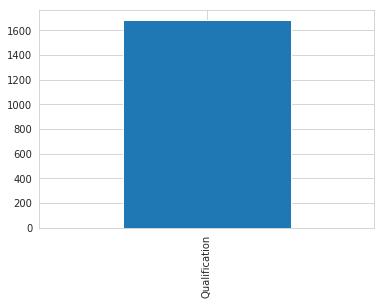

In [24]:
#missing values
sns.set_style("whitegrid")
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

In [25]:
# check number & percentage of missing value in the columns
def missing_values_table(df):
  mis_val = df.isnull().sum() #total missing values
  mis_val_percent = 100 * df.isnull().sum() / len(df) #percentage of missing values
  mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1) #make a table with the results
  mis_val_table_ren_columns = mis_val_table.rename(
  columns = {0 : 'Missing Values', 1 : '% of Total Values'}) #rename the columns
     # sort the table by percentage of missing value
  mis_val_table_ren_columns = mis_val_table_ren_columns[
  mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        #print same summary information
  print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

          # return the dataframe with missing information
  return mis_val_table_ren_columns
  
missing_values = missing_values_table(train)
missing_values.head()

Your selected dataframe has 17 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
Qualification,1679,4.400


In [0]:
cols_with_missing = [col for col in train.columns if train[col].isnull().any()]

reduced_train =train.drop(cols_with_missing, axis=1)
reduced_test = test.drop(cols_with_missing, axis=1)

In [27]:
#Handling missing values
train['Qualification'].unique()

array(['MSc, MBA and PhD', 'First Degree or HND', nan,
       'Non-University Education'], dtype=object)

In [0]:
train['Qualification'].fillna('uncertified',inplace=True)
test['Qualification'].fillna('uncertified',inplace=True)

In [0]:
def School_rank(Foreign_schooled,Qualification):
  if Foreign_schooled == 'Yes' and Qualification == 'MSc, MBA and PhD':
    return 5
  if Foreign_schooled == 'Yes' and Qualification == 'First Degree or HND':
    return 4
  if Foreign_schooled == 'No' and Qualification == 'MSc, MBA and PhD':
    return 3
  if Foreign_schooled == 'No' and Qualification == 'First Degree or HND':
    return 2
  else:
    return 1

In [0]:
#we could add hirarchical feature of people that foreigned schooled and PHD:4,with First degree :3,Local(PHD):3,Local Bsc:2,uneducated:1,noinfo:1 
train['School_rank']=train.apply(lambda x:School_rank(x['Foreign_schooled'],x['Qualification']),axis=1)
test['School_rank']=train.apply(lambda x:School_rank(x['Foreign_schooled'],x['Qualification']),axis=1)

In [31]:
train['School_rank'].value_counts()

4    23334
5     9591
1     2265
2     2244
3      878
Name: School_rank, dtype: int64

In [0]:
'''def ConvertQualificationToFeature(desc):
  Qualification={
      'MSc, MBA and PhD':5,
      'First Degree or HND':3,
      'Non-University Education':1,
      'uncertified':1
      }
  return Qualification[desc]'''

"def ConvertQualificationToFeature(desc):\n  Qualification={\n      'MSc, MBA and PhD':5,\n      'First Degree or HND':3,\n      'Non-University Education':1,\n      'uncertified':1\n      }\n  return Qualification[desc]"

In [0]:
#train['Qualification']=train['Qualification'].apply(ConvertQualificationToFeature)
#test['Qualification']=test['Qualification'].apply(ConvertQualificationToFeature)

In [32]:
train.head()
#qualification done

,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,School_rank
0,Commercial Sales and Marketing,"MSc, MBA and PhD",Female,Direct Internal process,2,1986,12.500,2011,1,0,41,ANAMBRA,No,Married,No,No,0,3
1,Customer Support and Field Operations,First Degree or HND,Male,Agency and others,2,1991,12.500,2015,0,0,52,ANAMBRA,Yes,Married,No,No,0,4
2,Commercial Sales and Marketing,First Degree or HND,Male,Direct Internal process,2,1987,7.500,2012,0,0,42,KATSINA,Yes,Married,No,No,0,4
3,Commercial Sales and Marketing,First Degree or HND,Male,Agency and others,3,1982,2.500,2009,0,0,42,NIGER,Yes,Single,No,No,1,4
4,Information and Strategy,First Degree or HND,Male,Direct Internal process,3,1990,7.500,2012,0,0,77,AKWA IBOM,Yes,Married,No,No,1,4


In [33]:
train['Gender'].unique()

array(['Female', 'Male'], dtype=object)

In [34]:
#one hot encode gender since it does not show hirarchy male cant be said to be more importance than female
train['Gender'].value_counts()

Male      26880
Female    11432
Name: Gender, dtype: int64

In [0]:
#one hot encode/label encode
train['Division'].value_counts()

Commercial Sales and Marketing                 11695
Customer Support and Field Operations           7973
Sourcing and Purchasing                         5052
Information Technology and Solution Support     4952
Information and Strategy                        3721
Business Finance Operations                     1786
People/HR Management                            1704
Regulatory and Legal services                    733
Research and Innovation                          696
Name: Division, dtype: int64

In [35]:
train['Division'].unique()

array(['Commercial Sales and Marketing',
       'Customer Support and Field Operations',
       'Information and Strategy',
       'Information Technology and Solution Support',
       'Sourcing and Purchasing', 'Business Finance Operations',
       'People/HR Management', 'Research and Innovation',
       'Regulatory and Legal services'], dtype=object)

In [0]:
def ConvertDivisionToFeature(desc):
  Division={
      'Commercial Sales and Marketing':'CSM',
      'Customer Support and Field Operations':'CSFO',
      'Information and Strategy':'IS',
      'Information Technology and Solution Support':'ITSS',
      'Sourcing and Purchasing':'SP',
      'Business Finance Operations':'BFO',
      'People/HR Management':'PHM',
      'Research and Innovation':'RI',
      'Regulatory and Legal services':'RLS'
      }
  return Division[desc]

In [0]:
train['Division']=train['Division'].apply(ConvertDivisionToFeature)
test['Division']=test['Division'].apply(ConvertDivisionToFeature)

In [39]:
train.head()

,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,School_rank
0,CSM,"MSc, MBA and PhD",Female,Direct Internal process,2,1986,12.500,2011,1,0,41,ANAMBRA,No,Married,No,No,0,3
1,CSFO,First Degree or HND,Male,Agency and others,2,1991,12.500,2015,0,0,52,ANAMBRA,Yes,Married,No,No,0,4
2,CSM,First Degree or HND,Male,Direct Internal process,2,1987,7.500,2012,0,0,42,KATSINA,Yes,Married,No,No,0,4
3,CSM,First Degree or HND,Male,Agency and others,3,1982,2.500,2009,0,0,42,NIGER,Yes,Single,No,No,1,4
4,IS,First Degree or HND,Male,Direct Internal process,3,1990,7.500,2012,0,0,77,AKWA IBOM,Yes,Married,No,No,1,4


In [40]:
#one encode/label encode
train['Channel_of_Recruitment'].value_counts()

Agency and others                  21310
Direct Internal process            16194
Referral and Special candidates      808
Name: Channel_of_Recruitment, dtype: int64

In [41]:
train['Channel_of_Recruitment'].unique()

array(['Direct Internal process', 'Agency and others',
       'Referral and Special candidates'], dtype=object)

In [0]:
def convertChannelToFeature(desc):
  Channel={
      'Direct Internal process':'DIP',
      'Agency and others':'AO',
      'Referral and Special candidates':'RSC'
      }
  return Channel[desc]

In [0]:
train['Channel_of_Recruitment']=train['Channel_of_Recruitment'].apply(convertChannelToFeature)
test['Channel_of_Recruitment']=test['Channel_of_Recruitment'].apply(convertChannelToFeature)

In [44]:
train.head()

,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,School_rank
0,CSM,"MSc, MBA and PhD",Female,DIP,2,1986,12.500,2011,1,0,41,ANAMBRA,No,Married,No,No,0,3
1,CSFO,First Degree or HND,Male,AO,2,1991,12.500,2015,0,0,52,ANAMBRA,Yes,Married,No,No,0,4
2,CSM,First Degree or HND,Male,DIP,2,1987,7.500,2012,0,0,42,KATSINA,Yes,Married,No,No,0,4
3,CSM,First Degree or HND,Male,AO,3,1982,2.500,2009,0,0,42,NIGER,Yes,Single,No,No,1,4
4,IS,First Degree or HND,Male,DIP,3,1990,7.500,2012,0,0,77,AKWA IBOM,Yes,Married,No,No,1,4


In [0]:
qualitative

['Division',
 'Qualification',
 'Gender',
 'Channel_of_Recruitment',
 'State_Of_Origin',
 'Foreign_schooled',
 'Marital_Status',
 'Past_Disciplinary_Action',
 'Previous_IntraDepartmental_Movement',
 'No_of_previous_employers']

In [50]:
train['State_Of_Origin'].value_counts()

SW    12273
SS     6567
NC     6503
SE     5305
NW     5107
NE     2557
Name: State_Of_Origin, dtype: int64

In [0]:
#categorized into six geo-political zones
def ConvertToGeoPoliticalZone(desc):
  
  State={
      
      'BENUE':'NC',
      'KOGI':'NC',
      'KWARA':'NC',
      'NASSARAWA':'NC',
      'NIGER':'NC',
      'PLATEAU':'NC',
      'FCT':'NC',
      
      'ADAMAWA':'NE',
      'BAUCHI':'NE',
      'BORNO':'NE',
      'GOMBE':'NE',
      'TARABA':'NE',
      'YOBE':'NE',
      
      
          
      'JIGAWA':'NW',
      'KADUNA':'NW',
      'KANO':'NW',
      'KATSINA':'NW',
      'KEBBI':'NW',
      'SOKOTO':'NW',
      'ZAMFARA':'NW',
      
          
      'ABIA':'SE',
      'ANAMBRA':'SE',
      'EBONYI':'SE',
      'ENUGU':'SE',
      'IMO':'SE',
      
      'AKWA IBOM':'SS',
      'BAYELSA':'SS',
      'CROSS RIVER':'SS',
      'RIVERS':'SS',
      'DELTA':'SS',
      'EDO':'SS',
     
        
      'EKITI':'SW',
      'LAGOS':'SW',
      'OGUN':'SW',
      'ONDO':'SW',
      'OSUN':'SW',
      'OYO':'SW'
      }
  return State[desc]

In [0]:
#one hot encode/label encode
train['State_Of_Origin']=train['State_Of_Origin'].apply(ConvertToGeoPoliticalZone)
test['State_Of_Origin']=test['State_Of_Origin'].apply(ConvertToGeoPoliticalZone)

In [51]:
train.head()

,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,School_rank
0,CSM,"MSc, MBA and PhD",Female,DIP,2,1986,12.500,2011,1,0,41,SE,No,Married,No,No,0,3
1,CSFO,First Degree or HND,Male,AO,2,1991,12.500,2015,0,0,52,SE,Yes,Married,No,No,0,4
2,CSM,First Degree or HND,Male,DIP,2,1987,7.500,2012,0,0,42,NW,Yes,Married,No,No,0,4
3,CSM,First Degree or HND,Male,AO,3,1982,2.500,2009,0,0,42,NC,Yes,Single,No,No,1,4
4,IS,First Degree or HND,Male,DIP,3,1990,7.500,2012,0,0,77,SS,Yes,Married,No,No,1,4


In [49]:
#hirarchy coding 2,1 
#one hot encode first later perform hirarchical encoding
train['Foreign_schooled'].value_counts()

Yes    34995
No      3317
Name: Foreign_schooled, dtype: int64

In [52]:
#one ehot encode
train['Marital_Status'].value_counts()

Married     31022
Single       6927
Not_Sure      363
Name: Marital_Status, dtype: int64

In [53]:
#Do Hirarchical encoding NO:1  ,yes :0
train['Past_Disciplinary_Action'].value_counts()

No     38161
Yes      151
Name: Past_Disciplinary_Action, dtype: int64

In [0]:
'''def ConvertDisciplinaryToFeature(desc):
  DisciplinaryAction={
      'Yes':0,
      'No':1
      
  }
  return DisciplinaryAction[desc]'''

"def ConvertDisciplinaryToFeature(desc):\n  DisciplinaryAction={\n      'Yes':0,\n      'No':1\n      \n  }\n  return DisciplinaryAction[desc]"

In [0]:
#it is logical to rate those without dicsciplinary action higher than those that have
#train['Past_Disciplinary_Action']=train['Past_Disciplinary_Action'].apply(ConvertDisciplinaryToFeature)
#test['Past_Disciplinary_Action']=test['Past_Disciplinary_Action'].apply(ConvertDisciplinaryToFeature)

In [54]:
train.head()

,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,School_rank
0,CSM,"MSc, MBA and PhD",Female,DIP,2,1986,12.500,2011,1,0,41,SE,No,Married,No,No,0,3
1,CSFO,First Degree or HND,Male,AO,2,1991,12.500,2015,0,0,52,SE,Yes,Married,No,No,0,4
2,CSM,First Degree or HND,Male,DIP,2,1987,7.500,2012,0,0,42,NW,Yes,Married,No,No,0,4
3,CSM,First Degree or HND,Male,AO,3,1982,2.500,2009,0,0,42,NC,Yes,Single,No,No,1,4
4,IS,First Degree or HND,Male,DIP,3,1990,7.500,2012,0,0,77,SS,Yes,Married,No,No,1,4


In [0]:
'''def Previous_IntraDepartmental_Movement(desc):
  Movement={
      'Yes':1,
      'No':0
      
  }
  return Movement[desc]'''

"def Previous_IntraDepartmental_Movement(desc):\n  Movement={\n      'Yes':1,\n      'No':0\n      \n  }\n  return Movement[desc]"

In [55]:

#You might want to try rating those with more intra deptmental movement high cos looks like they might understand the flow of the business more
#will try one hot encoding first
train['Previous_IntraDepartmental_Movement'].value_counts()

No     34709
Yes     3603
Name: Previous_IntraDepartmental_Movement, dtype: int64

In [0]:
#train['Previous_IntraDepartmental_Movement']=train['Previous_IntraDepartmental_Movement'].apply(Previous_IntraDepartmental_Movement)
#test['Previous_IntraDepartmental_Movement']=test['Previous_IntraDepartmental_Movement'].apply(Previous_IntraDepartmental_Movement)

In [56]:
train.head()

,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,School_rank
0,CSM,"MSc, MBA and PhD",Female,DIP,2,1986,12.500,2011,1,0,41,SE,No,Married,No,No,0,3
1,CSFO,First Degree or HND,Male,AO,2,1991,12.500,2015,0,0,52,SE,Yes,Married,No,No,0,4
2,CSM,First Degree or HND,Male,DIP,2,1987,7.500,2012,0,0,42,NW,Yes,Married,No,No,0,4
3,CSM,First Degree or HND,Male,AO,3,1982,2.500,2009,0,0,42,NC,Yes,Single,No,No,1,4
4,IS,First Degree or HND,Male,DIP,3,1990,7.500,2012,0,0,77,SS,Yes,Married,No,No,1,4


In [0]:
def ConvertNumberOfPreviousEmployerFeature(desc):
  Past={
      '0':'0',
      '1':'1',
      '2':'2',
      '3':'3',
      '4':'4',
      '5':'5',
      'More than 5':'7'
      }
  return Past[desc]

In [58]:

train['No_of_previous_employers'].value_counts()

1              18867
0              13272
2               1918
3               1587
4               1324
5                943
More than 5      401
Name: No_of_previous_employers, dtype: int64

In [59]:
train['No_of_previous_employers'].unique()

array(['0', '1', '4', '3', '2', 'More than 5', '5'], dtype=object)

In [0]:
#This column is not actually numerical col change to numerical and retry for other models like LGB,XGboost,Randomforest
train['No_of_previous_employers']=train['No_of_previous_employers'].apply(ConvertNumberOfPreviousEmployerFeature)
test['No_of_previous_employers']=test['No_of_previous_employers'].apply(ConvertNumberOfPreviousEmployerFeature)

In [62]:
train.head()

,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,School_rank
0,CSM,"MSc, MBA and PhD",Female,DIP,2,1986,12.500,2011,1,0,41,SE,No,Married,No,No,0,3
1,CSFO,First Degree or HND,Male,AO,2,1991,12.500,2015,0,0,52,SE,Yes,Married,No,No,0,4
2,CSM,First Degree or HND,Male,DIP,2,1987,7.500,2012,0,0,42,NW,Yes,Married,No,No,0,4
3,CSM,First Degree or HND,Male,AO,3,1982,2.500,2009,0,0,42,NC,Yes,Single,No,No,1,4
4,IS,First Degree or HND,Male,DIP,3,1990,7.500,2012,0,0,77,SS,Yes,Married,No,No,1,4


In [63]:
#no of years spent in establishment can be calculated
train['Year_of_recruitment'].value_counts()

2016    4916
2015    4757
2017    4656
2014    4101
2012    3909
2013    3314
2018    3194
2011    2011
2010    1865
2009    1497
2008     619
2007     570
2006     472
2004     422
2003     394
2005     376
2002     293
2001     269
2000     230
1999      90
1998      53
1995      51
1996      46
1997      38
1994      35
1993      27
1990      22
1991      21
1992      20
1988      13
1989      11
1987       8
1986       7
1985       4
1982       1
Name: Year_of_recruitment, dtype: int64

In [64]:
#age feature could be added
train['Year_of_birth'].value_counts()

1991    2544
1990    2506
1989    2441
1992    2380
1988    2268
1993    2217
1987    2157
1994    1985
1986    1882
1985    1766
1984    1505
1995    1416
1983    1342
1982    1195
1981    1162
1996     910
1980     893
1979     797
1978     685
1977     600
1997     596
1976     551
1975     508
1973     397
1974     394
1971     353
1972     312
1998     305
1970     256
1969     249
1968     233
1966     207
1967     195
1965     178
1964     168
1999     167
1963     161
1961     147
1962     134
2001      71
2000      66
1957       4
1958       3
1960       1
1959       1
1956       1
1955       1
1950       1
1952       1
Name: Year_of_birth, dtype: int64

In [0]:
from datetime import date
def CalculateYear(year):
  today=date.today()
  age=today.year-year
  return age


In [0]:
train['No_Of_Year_Spent']=train['Year_of_recruitment'].apply(CalculateYear)
test['No_Of_Year_Spent']=test['Year_of_recruitment'].apply(CalculateYear)

In [0]:
train['Age_in_years']=train['Year_of_birth'].apply(CalculateYear)
test['Age_in_years']=test['Year_of_birth'].apply(CalculateYear)

In [68]:
train.head()


,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,School_rank,No_Of_Year_Spent,Age_in_years
0,CSM,"MSc, MBA and PhD",Female,DIP,2,1986,12.500,2011,1,0,41,SE,No,Married,No,No,0,3,8,33
1,CSFO,First Degree or HND,Male,AO,2,1991,12.500,2015,0,0,52,SE,Yes,Married,No,No,0,4,4,28
2,CSM,First Degree or HND,Male,DIP,2,1987,7.500,2012,0,0,42,NW,Yes,Married,No,No,0,4,7,32
3,CSM,First Degree or HND,Male,AO,3,1982,2.500,2009,0,0,42,NC,Yes,Single,No,No,1,4,10,37
4,IS,First Degree or HND,Male,DIP,3,1990,7.500,2012,0,0,77,SS,Yes,Married,No,No,1,4,7,29


In [0]:
#dropping Year_of_recruitment and Year_of_birth
train.drop('Year_of_recruitment', axis = 1, inplace = True)
test.drop('Year_of_recruitment', axis = 1, inplace = True)

train.drop('Year_of_birth', axis = 1, inplace = True)
test.drop('Year_of_birth', axis = 1, inplace = True)


In [70]:
train.head()

,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Last_performance_score,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,School_rank,No_Of_Year_Spent,Age_in_years
0,CSM,"MSc, MBA and PhD",Female,DIP,2,12.500,1,0,41,SE,No,Married,No,No,0,3,8,33
1,CSFO,First Degree or HND,Male,AO,2,12.500,0,0,52,SE,Yes,Married,No,No,0,4,4,28
2,CSM,First Degree or HND,Male,DIP,2,7.500,0,0,42,NW,Yes,Married,No,No,0,4,7,32
3,CSM,First Degree or HND,Male,AO,3,2.500,0,0,42,NC,Yes,Single,No,No,1,4,10,37
4,IS,First Degree or HND,Male,DIP,3,7.500,0,0,77,SS,Yes,Married,No,No,1,4,7,29


In [71]:
train.dtypes

Division                                object
Qualification                           object
Gender                                  object
Channel_of_Recruitment                  object
Trainings_Attended                       int64
Last_performance_score                 float64
Targets_met                              int64
Previous_Award                           int64
Training_score_average                   int64
State_Of_Origin                         object
Foreign_schooled                        object
Marital_Status                          object
Past_Disciplinary_Action                object
Previous_IntraDepartmental_Movement     object
No_of_previous_employers                object
School_rank                              int64
No_Of_Year_Spent                         int64
Age_in_years                             int64
dtype: object

In [0]:
#train['Last_performance_score']=train['Last_performance_score'].round().astype('category')
test['Last_performance_score']=test['Last_performance_score'].round().astype('category')


In [0]:
#train['Last_performance_score']=np.log1p(train['Last_performance_score'])
#sns.distplot(np.log1p(train['Last_performance_score']))

In [0]:
#train['Training_score_average']=np.log1p(train['Training_score_average'])
#sns.distplot(np.log1p(train['Training_score_average']))

In [0]:
#test['Last_performance_score']=np.log1p(test['Last_performance_score'])
#test['Training_score_average']=np.log1p(test['Training_score_average'])


In [73]:
train.dtypes

Division                                object
Qualification                           object
Gender                                  object
Channel_of_Recruitment                  object
Trainings_Attended                       int64
Last_performance_score                 float64
Targets_met                              int64
Previous_Award                           int64
Training_score_average                   int64
State_Of_Origin                         object
Foreign_schooled                        object
Marital_Status                          object
Past_Disciplinary_Action                object
Previous_IntraDepartmental_Movement     object
No_of_previous_employers                object
School_rank                              int64
No_Of_Year_Spent                         int64
Age_in_years                             int64
dtype: object

In [0]:

'''0 Division                                object
1 Qualification                           int64
2 Gender                                  object
3 Channel_of_Recruitment                  object
4 Trainings_Attended     *                  int64
5 Last_performance_score *               float64
6 Targets_met     *                         int64
7 Previous_Award    *                       int64
8 Training_score_average  *                 int64
9 State_Of_Origin                         object
10 Foreign_schooled                        object
11 Marital_Status                          object
12 Past_Disciplinary_Action                 int64
13 Previous_IntraDepartmental_Movement      int64
14 No_of_previous_employers                 int64
15 No_Of_Year_Spent  *                       int64
16 Age_in_years  *'''

[0,1,2,3,9,10,11,12,13,14]

[0, 1, 2, 3, 9, 10, 11, 12, 13, 14]

In [0]:
['Trainings_Attended',
 'Year_of_birth',
 'Last_performance_score',
 'Year_of_recruitment',
 'Targets_met',
 'Previous_Award',
 'Training_score_average']

['Trainings_Attended',
 'Year_of_birth',
 'Last_performance_score',
 'Year_of_recruitment',
 'Targets_met',
 'Previous_Award',
 'Training_score_average']

In [0]:
qualitative

['Division',
 'Qualification',
 'Gender',
 'Channel_of_Recruitment',
 'State_Of_Origin',
 'Foreign_schooled',
 'Marital_Status',
 'Past_Disciplinary_Action',
 'Previous_IntraDepartmental_Movement',
 'No_of_previous_employers']

In [0]:
#extracting the index of categorical varriable
#categorical_var = np.where((train.dtypes != np.float)&(train.dtypes != np.int))[0]
#train.dtypes[f] != 'object']

In [0]:
#categorical_var

In [0]:
#label encode one hot encode categorical varribles

'''
qualitative_new=['Division',
 'Qualification',
 'Gender',
 'Channel_of_Recruitment',
 'State_Of_Origin',
 'Foreign_schooled',
 'Marital_Status',
 'Past_Disciplinary_Action',
 'Previous_IntraDepartmental_Movement',
  'No_of_previous_employers',
  ]

#LabelEncoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for column in qualitative_new :
    train[column] = le.fit_transform(train[column])
    

for column in qualitative_new :
    test[column] = le.fit_transform(test[column])'''
    
 
#one-hot encoder
'''for column in qualitative_new :
    dummies = pd.get_dummies(train[column], prefix=column[:5])
    train = pd.concat([train, dummies], axis=1)

for column in qualitative_new:
    dummies = pd.get_dummies(test[column], prefix=column[:5])
    test = pd.concat([test, dummies], axis=1)'''


#LabelEncoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
qualitative_4_labelEncode=['Division',
 'Qualification',
 'Channel_of_Recruitment',
 'State_Of_Origin'
  ]


for column in qualitative_4_labelEncode :
    train[column] = le.fit_transform(train[column])
    

for column in qualitative_4_labelEncode :
    test[column] = le.fit_transform(test[column])







In [0]:
#one hot encode categorical varriable
qualitative_4_one_hot=[
 'Gender',
 'Foreign_schooled',
 'Marital_Status',
 'Past_Disciplinary_Action',
 'Previous_IntraDepartmental_Movement',
  'No_of_previous_employers',
  ]

for column in qualitative_4_one_hot :
    dummies = pd.get_dummies(train[column], prefix=column[:5])
    train = pd.concat([train, dummies], axis=1)

for column in qualitative_4_one_hot:
    dummies = pd.get_dummies(test[column], prefix=column[:5])
    test = pd.concat([test, dummies], axis=1)
    
train.drop(qualitative_4_one_hot,axis=1,inplace=True)

test.drop(qualitative_4_one_hot,axis=1,inplace=True)

In [76]:
train.dtypes

Division                    int64
Qualification               int64
Channel_of_Recruitment      int64
Trainings_Attended          int64
Last_performance_score    float64
Targets_met                 int64
Previous_Award              int64
Training_score_average      int64
State_Of_Origin             int64
School_rank                 int64
No_Of_Year_Spent            int64
Age_in_years                int64
Gende_Female                uint8
Gende_Male                  uint8
Forei_No                    uint8
Forei_Yes                   uint8
Marit_Married               uint8
Marit_Not_Sure              uint8
Marit_Single                uint8
Past__No                    uint8
Past__Yes                   uint8
Previ_No                    uint8
Previ_Yes                   uint8
No_of_0                     uint8
No_of_1                     uint8
No_of_2                     uint8
No_of_3                     uint8
No_of_4                     uint8
No_of_5                     uint8
No_of_7       

In [0]:
#drop all categorical column
#train.drop(qualitative_new,axis=1,inplace=True)

In [0]:
#test.drop(qualitative_new,axis=1,inplace=True)

In [0]:
#train.drop('Qualification',axis=1,inplace=True)
#test.drop('Qualification',axis=1,inplace=True)

In [0]:
#converting from uint8 to int64
'''train[['Divis_BFO',
       'Divis_CSFO',
       'Divis_CSM','Divis_IS',
       'Divis_ITSS',
       'Divis_PHM',
       'Divis_RI',
       'Divis_RLS',
       'Divis_SP',                                
       'Gende_Female',                            
       'Gende_Male',                              
       'Chann_AO',                               
       'Chann_DIP',                             
       'Chann_RSC',                               
       'State_NC',                               
       'State_NE',                                
       'State_NW',                               
       'State_SE',                               
       'State_SS',                               
       'State_SW',                                
       'Forei_No',                               
       'Forei_Yes',                              
       'Marit_Married',                           
       'Marit_Not_Sure',                         
       'Marit_Single']].astype(np.int64)'''

"train[['Divis_BFO',\n       'Divis_CSFO',\n       'Divis_CSM','Divis_IS',\n       'Divis_ITSS',\n       'Divis_PHM',\n       'Divis_RI',\n       'Divis_RLS',\n       'Divis_SP',                                \n       'Gende_Female',                            \n       'Gende_Male',                              \n       'Chann_AO',                               \n       'Chann_DIP',                             \n       'Chann_RSC',                               \n       'State_NC',                               \n       'State_NE',                                \n       'State_NW',                               \n       'State_SE',                               \n       'State_SS',                               \n       'State_SW',                                \n       'Forei_No',                               \n       'Forei_Yes',                              \n       'Marit_Married',                           \n       'Marit_Not_Sure',                         \n       'Marit_Sing

In [77]:
train.dtypes

Division                    int64
Qualification               int64
Channel_of_Recruitment      int64
Trainings_Attended          int64
Last_performance_score    float64
Targets_met                 int64
Previous_Award              int64
Training_score_average      int64
State_Of_Origin             int64
School_rank                 int64
No_Of_Year_Spent            int64
Age_in_years                int64
Gende_Female                uint8
Gende_Male                  uint8
Forei_No                    uint8
Forei_Yes                   uint8
Marit_Married               uint8
Marit_Not_Sure              uint8
Marit_Single                uint8
Past__No                    uint8
Past__Yes                   uint8
Previ_No                    uint8
Previ_Yes                   uint8
No_of_0                     uint8
No_of_1                     uint8
No_of_2                     uint8
No_of_3                     uint8
No_of_4                     uint8
No_of_5                     uint8
No_of_7       

In [0]:
#train

In [0]:
'''
0-Qualification  *                        int64
1-Trainings_Attended                     int64
2-Last_performance_score                 int64
3-Targets_met    *                        int64
4-Previous_Award  *                       int64
5-Training_score_average                 int64
6-Past_Disciplinary_Action  *             int64
7-Previous_IntraDepartmental_Movement *   int64
8-No_of_previous_employers               int64
9-No_Of_Year_Spent                       int64
10-Age_in_years                           int64
Divis_BFO                              int64
Divis_CSFO                             int64
Divis_CSM                              int64
Divis_IS                               int64
Divis_ITSS                             int64
Divis_PHM                              int64
Divis_RI                               int64
Divis_RLS                              int64
Divis_SP                               int64
Gende_Female                           int64
Gende_Male                             int64
Chann_AO                               int64
Chann_DIP                              int64
Chann_RSC                              int64
State_NC                               int64
State_NE                               int64
State_NW                               int64
State_SE                               int64
State_SS                               int64
State_SW                               int64
Forei_No                               int64
Forei_Yes                              int64
Marit_Married                          int64
Marit_Not_Sure                         int64
Marit_Single'''

[0,3,4,6,7]

['Division',
 'Qualification',
 'Gender',
 'Channel_of_Recruitment',
 'State_Of_Origin',
 'Foreign_schooled',
 'Marital_Status',
 'Past_Disciplinary_Action',
 'Previous_IntraDepartmental_Movement',
 'No_of_previous_employers']


['Division',
 'Qualification',
 'Gender',
 'Channel_of_Recruitment',
 'State_Of_Origin',
 'Foreign_schooled',
 'Marital_Status',
 'Past_Disciplinary_Action',
 'Previous_IntraDepartmental_Movement',
 'No_of_previous_employers']

In [0]:
#This column is actually categorical column change to category and retry with other algorithm
#train['Targets_met'].unique()

In [0]:
#This column is actually categorical column change to category and retry with other algorithm
#train['Previous_Award'].unique()

In [0]:
# applying SMOTE cos of  large difference between 0s and 1s in target varriable

#from imblearn.over_sampling import SMOTE

#x_resample, y_resample = SMOTE().fit_sample(train, y_train.values.ravel()) 

# checking the shape of x_resample and y_resample
#print("Shape of x:", x_resample.shape)
#print("Shape of y:", y_resample.shape)

from imblearn.over_sampling import ADASYN 
sm = ADASYN()
train_resample,y_train_resample = sm.fit_sample(train,y_train)
train_resample = pd.DataFrame(train_resample, columns = train.columns)
y_train_resample=pd.DataFrame(y_train_resample)

In [81]:
# checking the shapes
print(train.shape)
print(train_resample.shape)
print(y_train_resample.shape)

(38312, 30)
(69681, 30)
(69681, 1)


In [0]:
# train and valid sets from train
from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import train_test_split

#x_trn, x_valid, y_trn, y_valid = train_test_split(train, y_train, test_size = 0.2, random_state = 0)

# checking the shapes
#print(x_trn.shape)
#print(y_train.shape)
#print(x_valid.shape)
#print(y_valid.shape)

In [0]:
'''from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_trn = sc.fit_transform(x_trn)
x_valid = sc.transform(x_valid)
test = sc.transform(test)'''

In [83]:
from sklearn.ensemble import RandomForestClassifier
model_RF=RandomForestClassifier(n_estimators=200,random_state=200,max_features=0.5,min_samples_leaf=3,oob_score=True,n_jobs=-1)
model_RF.fit(train_resample,y_train_resample)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=0.5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=True, random_state=200, verbose=0,
                       warm_start=False)

In [0]:
#Our Score on Validation Data
#model_RF.score(x_valid,y_valid)

0.9557614511288007

In [0]:
#Prediction on Test Set
predict_y_RF = model_RF.predict(test)

In [91]:
#Our Score on Training data
model_RF.score(train_resample,y_train_resample)

0.9802528666350943

In [0]:
#Prepare our Submission file
my_submission = pd.DataFrame({'EmployeeNo':test_ID, 'Promoted_or_Not': predict_y_RF })
my_submission.to_csv('submission_ayanlola.csv', index=False)

In [93]:
!kaggle competitions submit -c intercampusai2019 -f submission_ayanlola.csv -m "BOOTCAMP"

100% 226k/226k [00:09<00:00, 25.1kB/s]
403 - Your team has used its submission allowance (20 of 20). This resets at midnight UTC (49 minutes from now).


In [90]:
!kaggle competitions submissions -c intercampusai2019

fileName                 date                 description  status    publicScore  privateScore  
-----------------------  -------------------  -----------  --------  -----------  ------------  
submission_ayanlola.csv  2019-10-22 15:27:58  BOOTCAMP     complete  0.94543      None          
submission_ayanlola.csv  2019-10-22 15:26:49  BOOTCAMP     complete  0.94563      None          
submission_ayanlola.csv  2019-10-22 15:25:38  BOOTCAMP     complete  0.94543      None          
submission_ayanlola.csv  2019-10-22 15:24:47  BOOTCAMP     complete  0.94523      None          
submission_ayanlola.csv  2019-10-22 15:21:45  BOOTCAMP     complete  0.94624      None          
submission_ayanlola.csv  2019-10-22 15:20:41  BOOTCAMP     complete  0.94603      None          
submission_ayanlola.csv  2019-10-22 15:19:32  BOOTCAMP     complete  0.94543      None          
submission_ayanlola.csv  2019-10-22 15:17:36  BOOTCAMP     complete  0.94543      None          
submission_ayanlola.csv  2019-

In [0]:
#Applying ADABoost
#from sklearn.ensemble import AdaBoostClassifier
#from sklearn.model_selection import train_test_split

#x_trn,x_valid, y_trn, y_valid = train_test_split(train,y_train, test_size = 0.2, random_state = 0)

In [0]:
#model_ada = AdaBoostClassifier()
#model_ada.fit(train,y_train)

In [0]:
#Our Score on Validation Data
#model_ada.score(x_valid,y_valid)

In [0]:
#Prediction on Test Set
#predict_y_ada = model_ada.predict(test)

In [0]:
#Our Score on Training data
#model_ada.score(x_trn,y_trn)

In [0]:
#Prepare our Submission file
#my_submission = pd.DataFrame({'EmployeeNo':test_ID, 'Promoted_or_Not': predict_y_ada })
#my_submission.to_csv('submission_ayanlola.csv', index=False)

In [0]:
#!kaggle competitions submit -c intercampusai2019 -f submission_ayanlola.csv -m "BOOTCAMP"

In [0]:
#!kaggle competitions submissions -c intercampusai2019

In [0]:
'''import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

from sklearn.model_selection import train_test_split'''



In [0]:
#y_train.values

[array([0, 0, 0, ..., 0, 0, 0])]

In [0]:
'''def modelfit(alg,dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        #x_trn,x_valid, y_trn, y_valid = train_test_split(train,y_train, test_size = 0.2, random_state = 42)
        xgtrain = xgb.DMatrix(train.values, label=y_train.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds,show_progress=None)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors],y_train,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(y_train.values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, dtrain_predprob))
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')'''

Step 1: Fix learning rate and number of estimators for tuning tree-based parameters
In order to decide on boosting parameters, we need to set some initial values of other parameters. Lets take the following values:

max_depth = 5 : This should be between 3-10. I’ve started with 5 but you can choose a different number as well. 4-6 can be good starting points.
min_child_weight = 1 : A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups.
gamma = 0 : A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later.
subsample, colsample_bytree = 0.8 : This is a commonly used used start value. Typical values range between 0.5-0.9.
scale_pos_weight = 1: Because of high class imbalance.
Please note that all the above are just initial estimates and will be tuned later. Lets take the default learning rate of 0.1 here and check the optimum number of trees using cv function of xgboost. The function defined above will do it for us.


Model Report
Accuracy : 0.9433
AUC Score (Train): 0.929169


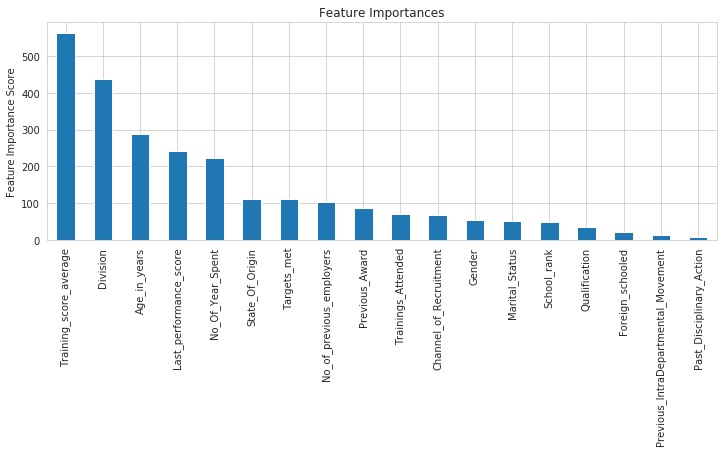

In [0]:
'''#Choose all predictors except target & IDcols
predictors =train.columns
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1,train,predictors)'''

Step 2: Tune max_depth and min_child_weight
We tune these first as they will have the highest impact on model outcome. To start with, let’s set wider ranges and then we will perform another iteration for smaller ranges.

Important Note: I’ll be doing some heavy-duty grid searched in this section which can take 15-30 mins or even more time to run depending on your system. You can vary the number of values you are testing based on what your system can handle.

In [0]:
'''param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_'''

({'mean_fit_time': array([ 56.953585  ,  55.5043457 ,  56.00189385,  91.29285293,
          91.28006182,  85.71473942, 134.2703505 , 130.29712286,
         125.7909627 , 177.47411499, 169.88382416, 138.62905002]),
  'mean_score_time': array([0.52305374, 0.5812685 , 0.65008755, 0.94943519, 0.94891033,
         1.02502785, 1.78739243, 1.67709527, 1.44253793, 2.51439214,
         2.25706487, 1.38450284]),
  'mean_test_score': array([0.89697253, 0.8969091 , 0.89679991, 0.8879783 , 0.88837545,
         0.88940486, 0.88205733, 0.88171729, 0.88362284, 0.87909118,
         0.87905334, 0.88063947]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[1, 3, 5, 1, 3, 5, 1, 3, 5, 1, 3, 5],
               mask=[False, False, False, False, False, Fals

Here, we have run 12 combinations with wider intervals between values. The ideal values are 5 for max_depth and 5 for min_child_weight. Lets go one step deeper and look for optimum values. We’ll search for values 1 above and below the optimum values because we took an interval of two.



In [0]:
'''param_test2 = {
 'max_depth':[4,5,7],
 'min_child_weight':[6,8,10,12]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=200, max_depth=5,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],y_train)
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_'''

({'mean_fit_time': array([14.19776492, 14.73983159, 14.59697795, 14.36377397, 18.39631443,
         18.19859858, 17.26704011, 17.87126136, 25.97681999, 24.57870102,
         25.24168544, 22.92190347]),
  'mean_score_time': array([0.14977703, 0.16550245, 0.16295471, 0.16496687, 0.1796072 ,
         0.18771868, 0.2094749 , 0.20641136, 0.2526669 , 0.23407507,
         0.23142881, 0.16694036]),
  'mean_test_score': array([0.8998882 , 0.90029457, 0.90068987, 0.90047171, 0.90003151,
         0.8997698 , 0.90032748, 0.90027984, 0.89747797, 0.89783398,
         0.89763659, 0.89768345]),
  'param_max_depth': masked_array(data=[4, 4, 4, 4, 5, 5, 5, 5, 7, 7, 7, 7],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[6, 8, 10, 12, 6, 8, 10, 12, 6, 8, 10, 12],
               mask=[False, False, False, False, False, False, Fal

Here, we get the optimum values as 4 for max_depth and 6 for min_child_weight. Also, we can see the CV score increasing slightly. Note that as the model performance increases, it becomes exponentially difficult to achieve even marginal gains in performance. You would have noticed that here we got 6 as optimum value for min_child_weight but we haven’t tried values more than 6. We can do that as follow:.



In [0]:
'''param_test2b = {
 'min_child_weight':[2,4,6,8]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=1000, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(train[predictors],y_train)
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_'''


({'mean_fit_time': array([14.19776492, 14.73983159, 14.59697795, 14.36377397, 18.39631443,
         18.19859858, 17.26704011, 17.87126136, 25.97681999, 24.57870102,
         25.24168544, 22.92190347]),
  'mean_score_time': array([0.14977703, 0.16550245, 0.16295471, 0.16496687, 0.1796072 ,
         0.18771868, 0.2094749 , 0.20641136, 0.2526669 , 0.23407507,
         0.23142881, 0.16694036]),
  'mean_test_score': array([0.8998882 , 0.90029457, 0.90068987, 0.90047171, 0.90003151,
         0.8997698 , 0.90032748, 0.90027984, 0.89747797, 0.89783398,
         0.89763659, 0.89768345]),
  'param_max_depth': masked_array(data=[4, 4, 4, 4, 5, 5, 5, 5, 7, 7, 7, 7],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[6, 8, 10, 12, 6, 8, 10, 12, 6, 8, 10, 12],
               mask=[False, False, False, False, False, False, Fal

In [0]:
#modelfit(gsearch3.best_estimator_, train, predictors)
#gsearch2b.grid_scores_, gsearch2b.best_params_, gsearch2b.best_score_

Step 3: Tune gamma
Now lets tune gamma value using the parameters already tuned above. Gamma can take various values but I’ll check for 5 values here. You can go into more precise values as.

In [0]:
'''param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=4,
 min_child_weight=10, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],y_train)
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_'''

({'mean_fit_time': array([14.46140304, 14.58408155, 14.53276958, 14.14058838, 12.8772943 ]),
  'mean_score_time': array([0.16142735, 0.16977506, 0.16438503, 0.17931528, 0.12060461]),
  'mean_test_score': array([0.90068987, 0.90072779, 0.90113147, 0.90076203, 0.90081141]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'rank_test_score': array([5, 4, 1, 3, 2], dtype=int32),
  'split0_test_score': array([0.90401923, 0.9031838 , 0.90381792, 0.90317842, 0.90368581]),
  'split1_test_score': array([0.89894065, 0.8984883 , 0.89965241, 0.90031533, 0.89979906]),
  'split2_test_score': array([0.89636512, 0.89719129, 0.89736466, 0.896965  , 0.89763859]),
  'split3_test_score': array([0.90212542, 0.90202553, 0.90207251, 0.90166448, 0.90154787]),
  'split4_test_score':

This shows that our original value of gamma, i.e. 0 is the optimum one. Before proceeding, a good idea would be to re-calibrate the number of boosting rounds for the updated parameters.


Model Report
Accuracy : 0.9454
AUC Score (Train): 0.948058


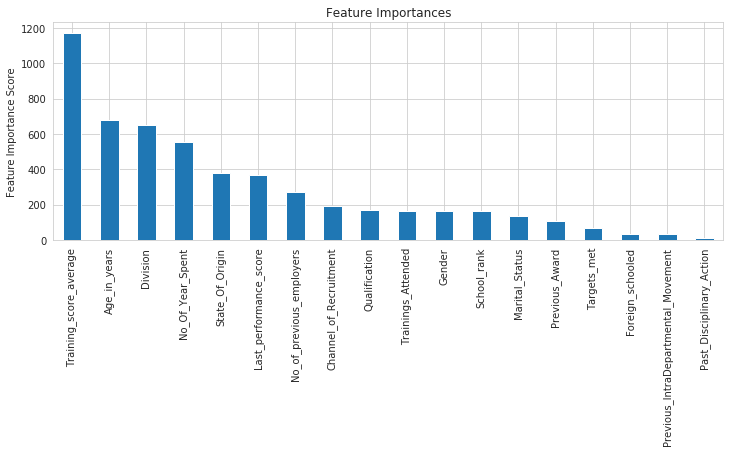

In [0]:
'''xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=7,
 min_child_weight=2,
 gamma=0.2,
 subsample=0.9,
 colsample_bytree=0.7,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, train, predictors)'''

Here, we can see the improvement in score. So the final parameters are:

max_depth: 4
min_child_weight: 6
gamma: 0


Step 4: Tune subsample and colsample_bytree
The next step would be try different subsample and colsample_bytree values. Lets do this in 2 stages as well and take values 0.6,0.7,0.8,0.9 for both to start with.



In [0]:
'''param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=7,
 min_child_weight=2, gamma=0.2, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],y_train)
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_'''

({'mean_fit_time': array([115.32677112, 115.08496647, 107.53971896, 104.47023973,
         129.72693295, 125.52523527, 120.80295844, 112.42170997,
         141.15277381, 138.08172889, 131.20819335, 122.86698179,
         153.22739029, 149.46582608, 139.67086444, 130.3339633 ]),
  'mean_score_time': array([1.54992862, 1.60797215, 1.67016478, 1.78324046, 1.62358813,
         1.72095833, 1.6406507 , 1.6799284 , 1.70844874, 1.86766629,
         1.58677955, 1.66852541, 1.79106317, 1.65703053, 1.76089292,
         1.23994937]),
  'mean_test_score': array([0.88039718, 0.88136794, 0.88190745, 0.8830116 , 0.87973863,
         0.88182553, 0.88200196, 0.88408538, 0.87942397, 0.88027735,
         0.88223575, 0.88214111, 0.87906443, 0.87982719, 0.88173677,
         0.88218523]),
  'param_colsample_bytree': masked_array(data=[0.6, 0.6, 0.6, 0.6, 0.7, 0.7, 0.7, 0.7, 0.8, 0.8, 0.8,
                     0.8, 0.9, 0.9, 0.9, 0.9],
               mask=[False, False, False, False, False, False, False, Fals

Here, we found 0.8 as the optimum value for both subsample and colsample_bytree. Now we should try values in 0.05 interval around these.

In [0]:
'''param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=7,
 min_child_weight=2, gamma=0.2, subsample=0.9, colsample_bytree=0.7,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],y_train)'''

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0.2,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=7, min_child_weight=2,
                                     missing=None, n_estimators=1000, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'colsample_bytree': [0.75, 0.8, 0.85],
                         'subsample': [0.75, 0.8, 0.85]},
             pre_dispatch='2*n_jobs', refit=Tru

In [0]:
#gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

({'mean_fit_time': array([129.37512946, 123.74458337, 123.60911303, 133.99664927,
         130.04561439, 127.40272746, 140.66633673, 134.4283236 ,
         116.75898919]),
  'mean_score_time': array([1.57222662, 1.67453456, 1.55788441, 1.86589403, 1.52424335,
         1.58048725, 1.51564498, 1.59211879, 1.02683215]),
  'mean_test_score': array([0.88011666, 0.88157161, 0.88232149, 0.8812874 , 0.88223575,
         0.88234874, 0.88050994, 0.8805151 , 0.8822071 ]),
  'param_colsample_bytree': masked_array(data=[0.75, 0.75, 0.75, 0.8, 0.8, 0.8, 0.85, 0.85, 0.85],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_subsample': masked_array(data=[0.75, 0.8, 0.85, 0.75, 0.8, 0.85, 0.75, 0.8, 0.85],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'params': [{'colsampl

Again we got the same values as before. Thus the optimum values are:

subsample: 0.8
colsample_bytree: 0.8

Step 5: Tuning Regularization Parameters
Next step is to apply regularization to reduce overfitting. Though many people don’t use this parameters much as gamma provides a substantial way of controlling complexity. But we should always try it. I’ll tune ‘reg_alpha’ value here and leave it upto you to try different values of ‘reg_lambda’.

In [0]:
'''param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=7,
 min_child_weight=2, gamma=0.2, subsample=0.9, colsample_bytree=0.7,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],y_train)
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_'''

({'mean_fit_time': array([111.73234344, 114.33195248, 114.74338517, 115.94490676,
          29.12585487]),
  'mean_score_time': array([1.57713394, 1.60165906, 1.43790789, 1.64909115, 0.13619161]),
  'mean_test_score': array([0.88408534, 0.88312545, 0.88260328, 0.88473595, 0.87512685]),
  'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 1e-05},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.1},
   {'reg_alpha': 1},
   {'reg_alpha': 100}],
  'rank_test_score': array([2, 3, 4, 1, 5], dtype=int32),
  'split0_test_score': array([0.88221629, 0.88056718, 0.88030975, 0.88322316, 0.87156896]),
  'split1_test_score': array([0.88385971, 0.88395321, 0.88167162, 0.88428962, 0.87559691]),
  'split2_test_score': array([0.87734364, 0.87475875, 0.87532585, 0.87881512, 0.87280708]),
  'split3_test_score': array([0.88517432, 0.88711928, 0.88512459, 0.887618

We can see that the CV score is less than the previous case. But the values tried are very widespread, we should try values closer to the optimum here (0.01) to see if we get something better.



You can see that we got a better CV. Now we can apply this regularization in the model and look at the impact:


Model Report
Accuracy : 0.9446
AUC Score (Train): 0.944405


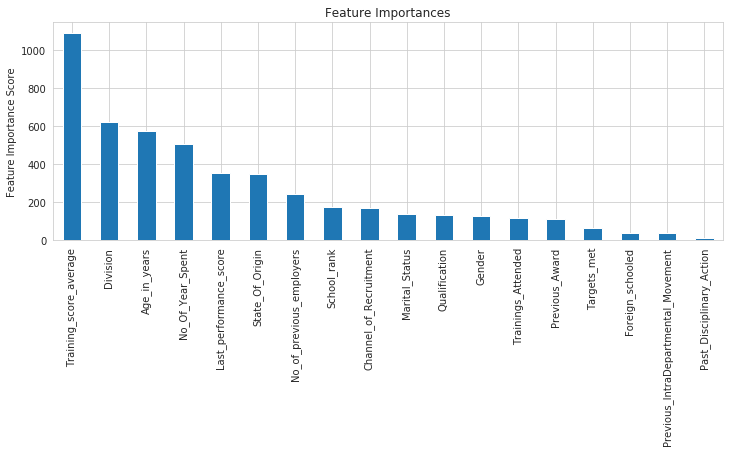

In [0]:
'''
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=7,
 min_child_weight=2,
 gamma=0.2,
 subsample=0.9,
 colsample_bytree=0.7,
 reg_alpha=1,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, train, predictors)'''

Again we can see slight improvement in the score.

Step 6: Reducing Learning Rate
Lastly, we should lower the learning rate and add more trees. Lets use the cv function of XGBoost to do the job again.


Model Report
Accuracy : 0.9431
AUC Score (Train): 0.931335


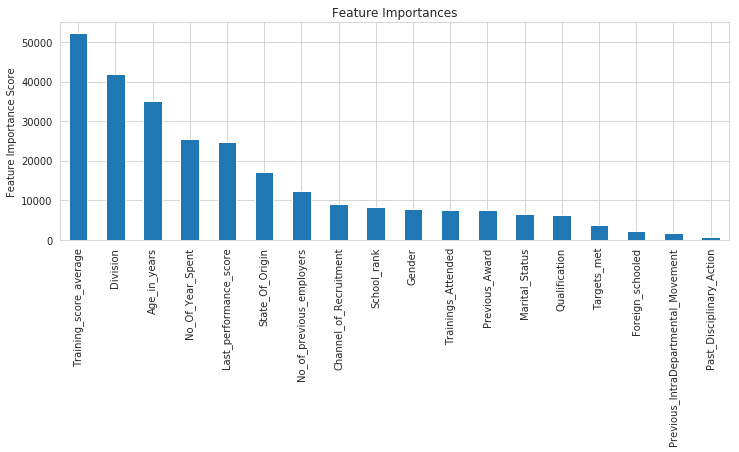

In [0]:
'''xgb4 = XGBClassifier(
 learning_rate =0.03,
 n_estimators=5000,
 max_depth=7,
 min_child_weight=2,
 gamma=.2,
 subsample=0.9,
 colsample_bytree=0.7,
 reg_alpha=1,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, train, predictors)'''

In [0]:
#Applying XGBOOST
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

x_trn,x_valid, y_trn, y_valid = train_test_split(train,y_train, test_size = 0.2, random_state = 42)
#x_trn,x_valid, y_trn, y_valid = train_test_split(train,y_train, test_size = 0.2, random_state = 42)

In [0]:
#parameter tuning
'''from sklearn import metrics
from sklearn.model_selection import GridSearchCV

model_xg =XGBClassifier()
param_dist = {"max_depth": [3,5,7],
              "min_child_weight" : [1,3,6],
              "n_estimators": [140],
              "learning_rate": [0.05, 0.1,0.16],
              "gamma":[0]}
grid_search = GridSearchCV(model_xg, param_grid=param_dist, cv = 3, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(train, y_train)

grid_search.best_estimator_'''

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  3.6min finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.16, max_delta_step=0, max_depth=3,
              min_child_weight=6, missing=None, n_estimators=140, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:

model_xg = XGBClassifier(
 learning_rate =0.1,
 n_estimators=200,
 max_depth=7,
 min_child_weight=2,
 gamma=0.2,
 subsample=0.9,
 colsample_bytree=0.7,
 reg_alpha=0.001,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
model_xg.fit(train,y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.2,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=2, missing=None, n_estimators=200, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0.001, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.9, verbosity=1)

In [0]:
'''model_xg =XGBClassifier(n_estimators=30,learning_rate =0.3,max_depth=3,
                        min_child_weight=1,gamma=0.3,subsample=0.8,colsample_bytree=0.8,
                        objective= 'binary:logistic',nthread=4,scale_pos_weight=1,reg_alpha=1e-05,
                        reg_lambda=1,seed=27)

model_xg.fit(train,y_train)'''

"model_xg =XGBClassifier(n_estimators=30,learning_rate =0.3,max_depth=3,\n                        min_child_weight=1,gamma=0.3,subsample=0.8,colsample_bytree=0.8,\n                        objective= 'binary:logistic',nthread=4,scale_pos_weight=1,reg_alpha=1e-05,\n                        reg_lambda=1,seed=27)\n\nmodel_xg.fit(train,y_train)"

In [0]:
#Our Score on Validation Data
model_xg.score(x_valid,y_valid)

0.9462351559441472

In [0]:
#Prediction on Test Set
predict_y_xg = model_xg.predict(test)

In [0]:
#Our Score on Training data
model_xg.score(x_trn,y_trn)

0.9522007243303208

In [0]:
#Prepare our Submission file
my_submission = pd.DataFrame({'EmployeeNo':test_ID, 'Promoted_or_Not': predict_y_xg })
my_submission.to_csv('submission_ayanlola.csv', index=False)

In [0]:
!kaggle competitions submit -c intercampusai2019 -f submission_ayanlola.csv -m "BOOTCAMP"

100% 226k/226k [00:00<00:00, 865kB/s]
403 - Your team has used its submission allowance (20 of 20). This resets at midnight UTC (8.4 hours from now).


In [0]:
!kaggle competitions submissions -c intercampusai2019

fileName                 date                 description  status    publicScore  privateScore  
-----------------------  -------------------  -----------  --------  -----------  ------------  
submission_ayanlola.csv  2019-10-22 15:27:58  BOOTCAMP     complete  0.94543      None          
submission_ayanlola.csv  2019-10-22 15:26:49  BOOTCAMP     complete  0.94563      None          
submission_ayanlola.csv  2019-10-22 15:25:38  BOOTCAMP     complete  0.94543      None          
submission_ayanlola.csv  2019-10-22 15:24:47  BOOTCAMP     complete  0.94523      None          
submission_ayanlola.csv  2019-10-22 15:21:45  BOOTCAMP     complete  0.94624      None          
submission_ayanlola.csv  2019-10-22 15:20:41  BOOTCAMP     complete  0.94603      None          
submission_ayanlola.csv  2019-10-22 15:19:32  BOOTCAMP     complete  0.94543      None          
submission_ayanlola.csv  2019-10-22 15:17:36  BOOTCAMP     complete  0.94543      None          
submission_ayanlola.csv  2019-

In [0]:
#Applying light boost classifier
#from lightgbm import LGBMClassifier
#from sklearn.model_selection import train_test_split

#x_trn,x_valid, y_trn, y_valid = train_test_split(train,y_train, test_size = 0.2, random_state = 0)











In [0]:

#model_lgb =LGBMClassifier(n_estimators=400,num_leaves=100,verbosity=0)
#model_lgb.fit(train,y_train)

In [0]:
#Our Score on Validation Data
#model_lgb.score(x_valid,y_valid)

In [0]:
#Prediction on Test Set
#predict_y_lgb = model_lgb.predict(test)

In [0]:

#Our Score on Training data
#model_lgb.score(x_trn,y_trn)

In [0]:
#Prepare our Submission file
#my_submission = pd.DataFrame({'EmployeeNo':test_ID, 'Promoted_or_Not': predict_y_lgb })
#my_submission.to_csv('submission_ayanlola.csv', index=False)

In [0]:
#!kaggle competitions submit -c intercampusai2019 -f submission_ayanlola.csv -m "BOOTCAMP"

In [0]:
#!kaggle competitions submissions -c intercampusai2019

In [0]:
!pip install catboost==0.7.2

     |████████████████████████████████| 33.4MB 75.4MB/s 


In [0]:
#applying catboost
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.model_selection import train_test_split

x_trn,x_valid, y_trn, y_valid = train_test_split(train,y_train, test_size = 0.2, random_state = 0)


In [0]:
#categorical_var = np.where(train_x.dtypes != np.float)[0]

In [0]:
cat_features=[0,3,4,6,7]
model_cat = CatBoostClassifier(iterations = 5000,
                                
                                eval_metric='AUC',
                                loss_function= 'Logloss',
                                learning_rate=0.003,
                                depth=5,
                                leaf_estimation_iterations = 10
                                )

#model_cat=CatBoostClassifier()



In [0]:
model_cat.fit(train,y_train,cat_features)

0:	learn: 0.6655175	total: 141ms	remaining: 11m 43s
1:	learn: 0.8248512	total: 234ms	remaining: 9m 45s
2:	learn: 0.8297307	total: 316ms	remaining: 8m 47s
3:	learn: 0.8219482	total: 418ms	remaining: 8m 41s
4:	learn: 0.8213033	total: 506ms	remaining: 8m 25s
5:	learn: 0.8208664	total: 592ms	remaining: 8m 13s
6:	learn: 0.8241050	total: 681ms	remaining: 8m 5s
7:	learn: 0.8261566	total: 767ms	remaining: 7m 58s
8:	learn: 0.8380726	total: 850ms	remaining: 7m 51s
9:	learn: 0.8362611	total: 940ms	remaining: 7m 49s
10:	learn: 0.8356348	total: 1.03s	remaining: 7m 46s
11:	learn: 0.8355860	total: 1.11s	remaining: 7m 43s
12:	learn: 0.8311749	total: 1.21s	remaining: 7m 43s
13:	learn: 0.8284447	total: 1.3s	remaining: 7m 42s
14:	learn: 0.8282980	total: 1.39s	remaining: 7m 43s
15:	learn: 0.8265633	total: 1.48s	remaining: 7m 41s
16:	learn: 0.8254120	total: 1.58s	remaining: 7m 43s
17:	learn: 0.8242534	total: 1.67s	remaining: 7m 41s
18:	learn: 0.8246667	total: 1.76s	remaining: 7m 41s
19:	learn: 0.8240068	to

In [0]:
#Our Score on Validation Data
model_cat.score(x_valid,y_valid)

0.9483231110531124

In [0]:
#Prediction on Test Set
predict_y_cat = model_cat.predict(test)

In [0]:
#Our Score on Training data
model_cat.score(x_trn,y_trn)

0.9423798492609873

In [0]:
#Prepare our Submission file
my_submission = pd.DataFrame({'EmployeeNo':test_ID, 'Promoted_or_Not': predict_y_cat })
my_submission.to_csv('submission_ayanlola.csv', index=False)

In [0]:
!kaggle competitions submit -c intercampusai2019 -f submission_ayanlola.csv -m "BOOTCAMP"

100% 258k/258k [00:02<00:00, 88.6kB/s]
Successfully submitted to Data Science Nigeria Staff Promotion Algorithm 

In [0]:
!kaggle competitions submissions -c intercampusai2019

fileName                 date                 description  status    publicScore  privateScore  
-----------------------  -------------------  -----------  --------  -----------  ------------  
submission_ayanlola.csv  2019-10-16 23:41:51  BOOTCAMP     complete  0.00000      None          
submission_ayanlola.csv  2019-10-16 22:44:42  BOOTCAMP     complete  0.00000      None          
submission_ayanlola.csv  2019-10-15 23:27:06  BOOTCAMP     complete  0.94523      None          
submission_ayanlola.csv  2019-10-15 23:12:32  BOOTCAMP     complete  0.94159      None          
submission_ayanlola.csv  2019-10-15 15:23:23  BOOTCAMP     complete  0.94058      None          
submission_ayanlola.csv  2019-10-15 05:36:14  BOOTCAMP     complete  0.94139      None          
submission_ayanlola.csv  2019-10-15 05:11:08  BOOTCAMP     complete  0.94523      None          
submission_ayanlola.csv  2019-10-15 02:58:16  BOOTCAMP     complete  0.94159      None          
submission_ayanlola.csv  2019-